# Powereign tasks_觀察爛電池

In [23]:
'''1215資料抓完了,剩下訓練'''
import numpy as np
import pandas as pd

data = r'C:\Users\Chun-Po\Documents\Python Scripts\儲存分析結果(數據)\皓恆任務.csv'         # [:,[9,19,12,13,14,15,16,17]]
misson = np.genfromtxt(data, dtype = None, delimiter = ',', skip_header = 0, filling_values = 0, invalid_raise = False, encoding = 'latin-1')[:,[2,3,13,14,16,17,21,24,25,26,27]]
print("mission\n", misson[0])
np.savetxt(r'C:\Users\Chun-Po\Documents\Python Scripts\儲存分析結果(數據)\皓恆任務_Mission.csv',misson,delimiter=',',fmt='%s')

mission
 ['Mileage' 'MIS' 'CHR_Time' 'DIS_Time' 'V15min' 'V20min' 'DIS0_Time'
 'Rex 3min' 'Rex10min' 'Inflection' 'VPVD (Self)']


In [91]:
'''Import資料'''
import torch
from torch import nn, optim
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
import pylab as plot

data = '皓恆任務_Mission_無nan_Uploaded.csv'         # [:,[9,19,12,13,14,15,16,17]]
mission2 = np.genfromtxt(data, dtype = None, delimiter = ',', skip_header = 0, filling_values = 0, invalid_raise = False, encoding = 'latin-1')
print(mission2[0])

(58135, 25.9, 0.02430556, 0.02388889, 8.0096, 8.1552, 0.0190625, -0.218, -0.277, 1220, 8.67)


In [93]:
data = np.empty((765,11), dtype = object);
for i in range(11):
    for j in range(765):
        data[j,i] = mission2[j][i]
print(data[0:2,2:11])

[[0.024305556 0.023888889 8.0096 8.1552 0.0190625 -0.218 -0.277 1220 8.67]
 [0.024305556 0.023668981 8.0091 8.1656 0.019375 -0.234 -0.306 1230 8.7]]


In [100]:
'''FeedForward Neural Network'''
import torch
from torch import nn, optim
from IPython import display
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp

scaler = pp.MinMaxScaler().fit(data[:,2:11])     # 默認數據壓縮范圍為[0,1]
data_var = scaler.transform(data[:,2:11])
data_SOH = data[:,0:1]
data_all = np.hstack((data_SOH, data_var))     # 製作normalized features+未調整SOH數據
print("data_all\n", data_all[0])

data_all
 [58135 1.0 0.7500002250000222 0.10346469817835491 0.11937838474217166
 0.6924769016846707 0.9087301587301588 0.8840764331210191
 0.6014277215942891 0.3333333333333339]


In [102]:
features_train, features_test, milg_train, milg_test = train_test_split(data_all[:,2:11], data_all[:,0:1].ravel(), test_size=0.2, random_state=100)
print("features_train\n", features_train[0])

features_train
 [0.6718752671875272 0.1079890463150388 0.1362137979750404
 0.7540694950191903 0.8544973544973546 0.8063694267515924
 0.6252230814991077 0.38383838383838587]


In [126]:
X_train = torch.from_numpy(features_train.astype(np.float64))
y_train = torch.from_numpy(milg_train.astype(np.float64))
X_test = torch.from_numpy(features_test.astype(np.float64))
y_test = torch.from_numpy(milg_test.astype(np.float64))

D = 8  # dimensions
C = 1  # num_classes
H1 = 100  # num_hidden_units_1
H2 = 20  # num_hidden_units_2

learning_rate = 6e-3
lambda_l2 = 5e-5
n_networks = 1     # Number of networks
criterion = torch.nn.MSELoss()     # nn package also has different loss functions. We use MSE for a regression task
totalerr_train = []; totalerr_test = []; total_corr = [];
train_set = []; test_set = []; eveloss = [];
models = list(); y_pretrain = list()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for mod in range(n_networks):
    model = nn.Sequential(
        nn.Linear(D, H1),
        nn.ReLU(), 
        nn.Linear(H1, H2),
        nn.ReLU(),
        nn.Linear(H2, C),
    )
    model.to(device)
  # Append models
    models.append(model)
  # Use the optim package to apply ADAM for our parameter updates
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)     # built-in L2
    for t in range(50000):
      # Feed forward to get the logits     # print("test_set = ", test_set);     # 檢查是否正確取樣
        y_pred = model(X_train.float())
        if t == 0:
            y_pretrain.append(y_pred.detach())
          # Compute the loss and accuracy
        loss = torch.sqrt(criterion(y_pred.float(), y_train.float()))
        eveloss.append(np.round(loss.item(),6))
        print(f"[EPOCH]: {t}, [LOSS]: {loss.item():.6f}")
        display.clear_output(wait=True)
      # zero the gradients before running
      # the backward pass.
        optimizer.zero_grad()
      # Backward pass to compute the gradient of loss w.r.t our learnable params. 
        loss.backward()
      # Update params
        optimizer.step()
        if t == 49999:
            totalerr_train.append(np.round(loss.item(),6))  
          ## Testing
            y_test_pred = model(X_test.float())
          # Compute the loss and accuracy
            loss_test = torch.sqrt(criterion(y_test_pred.float(), y_test.float()))
            y_test_array = []; y_test_pred_array = [];
            for ii in range(len(y_test)):
                y_test_array.append(y_test.detach().numpy()[ii].astype(np.float64))     # [ii]後面有時候要加[0]有時不用,使用時請注意資料集種類
                y_test_pred_array.append(y_test_pred.detach().numpy()[ii][0].astype(np.float64))
            R_sq = np.round(r2_score(y_test_pred_array, y_test_array),3)
            MAE = np.round(mean_absolute_error(y_test_pred_array, y_test_array),3)
            totalerr_test.append(np.round(loss_test.item(),6))
            total_corr.append(np.round(R_sq,3))


C:\Users\Chun-Po\miniconda3\envs\env_pytorch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([153])) that is different to the input size (torch.Size([153, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


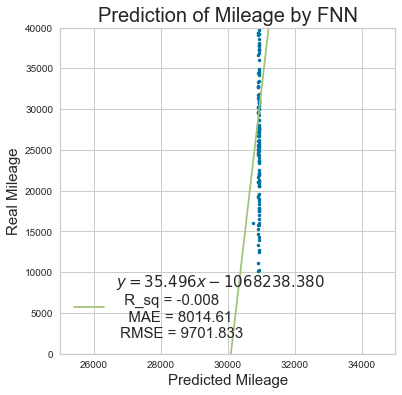

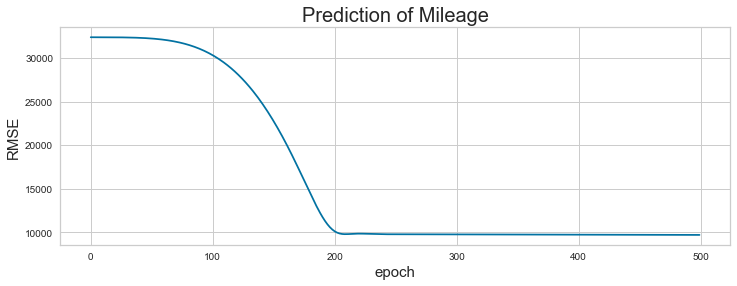

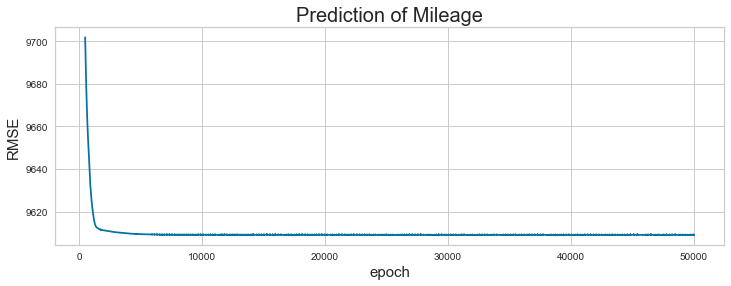

hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20;;,learning_rate = 0.006, lambda_l2 = 5e-05
Result_train =  [9609.168945]
9609.169
Result_test =  [9701.833008]
9701.833
total_corr(^2) =  [-391640.158]
-391640.158


In [143]:
plt.figure(figsize=(6,6))
plt.plot(y_test_pred_array, y_test_array, 'b.');     #
m1, b1 = np.polyfit(y_test_pred_array, y_test_array, 1);
plt.axline(xy1=(0, b1), slope=m1, color='g', label=f'$y = {m1:.3f}x {b1:+.3f}$\n  R_sq = {R_sq}\n   MAE = {MAE}\n RMSE = {loss_test:.3f}') # 
plt.xlim(25000, 35000)
plt.ylim(0, 40000)
plt.xlabel("Predicted Mileage", fontsize=15)
plt.ylabel("Real Mileage", fontsize=15)
plt.title("Prediction of Mileage by FNN", fontsize=20);
plt.legend(fontsize=15)
plt.savefig("Prediction of Mileage by FNN" + ".jpg"); plt.show();  #save as jpg
plt.figure(figsize=(12,4))
plt.plot(np.arange(0,500,1),eveloss[0:500]);     # ,'ro'
plt.xlabel("epoch", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.title("Prediction of Mileage", fontsize=20);
plt.savefig("Prediction of Mileage" + ".jpg"); plt.show();     #save as jpg
plt.figure(figsize=(12,4))
plt.plot(np.arange(499,50000,1),eveloss[499:50000]);     # ,'ro'
plt.xlabel("epoch", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.title("Prediction of Mileage", fontsize=20);
plt.savefig("Prediction of Mileage" + ".jpg"); plt.show();     #save as jpg'''

print("hyperparameters = ", 'Epoch = ' + f"{t+1}" + ',' + ' hidden_1= ' + f"{H1}" + ';;' + ' hidden_2= ' + f"{H2}" + ';;' + ',' + 'learning_rate = ' + f"{learning_rate}" + ', ' + "lambda_l2 = " + f"{lambda_l2}")
# print("hyperparameters = ", 'Epoch = ' + f"{t+1}" + ',' + ' hidden_1= ' + f"{H1}" + ';;' + ' hidden_2= ' + f"{H2}" + ';;' + ' hidden_3= ' + f"{H3}" + ',' + 'learning_rate = ' + f"{learning_rate}" + ', ' + "lambda_l2 = " + f"{lambda_l2}")
# print("hyperparameters = ", 'Epoch = ' + f"{t+1}" + ',' + ' hidden_1= ' + f"{H1}" + ';;' + ' hidden_2= ' + f"{H2}" + ';;' + ' hidden_3= ' + f"{H3}" + ' hidden_4= ' + f"{H4}" + ',' + 'learning_rate = ' + f"{learning_rate}" + ', ' + "lambda_l2 = " + f"{lambda_l2}")
print("Result_train = ", totalerr_train); print(np.round(np.mean(totalerr_train),3))
print("Result_test = ", totalerr_test); print(np.round(np.mean(totalerr_test),3))
print("total_corr(^2) = ", total_corr); print(np.round(np.mean(total_corr),3))


In [140]:
'''1215,Random Forest。以下示範"森林中的樹木量"不同時,模型損失的變化'''
features_train, features_test, milg_train, milg_test = train_test_split(data[:,2:11], data[:,0:1].ravel(), test_size=0.2, random_state=100)
print("features_train\n", features_train)

features_train
 [[0.024305556 0.023715278 8.0134 ... -0.338 1260 8.72]
 [0.024305556 0.02306713 8.0121 ... -0.337 1180 8.74]
 [0.024305556 0.023680556 8.0345 ... -0.313 1260 8.66]
 ...
 [0.024305556 0.022280093 8.0225 ... -0.356 1180 8.75]
 [0.024305556 0.022928241 8.0001 ... -0.364 1210 8.76]
 [0.024305556 0.023425926 8.0407 ... -0.308 1230 8.68]]


In [141]:
rmseoos = []
ntreelist = range(50, 1000, 50)
for itrees in ntreelist:
    depth = None
    maxfeat = None
    model = ensemble.RandomForestRegressor(n_estimators=itrees, max_depth=depth, max_features=maxfeat, oob_score=False, random_state=100)
    model.fit(features_train, milg_train)
    predictions = model.predict(features_test)
    rmseoos.append(math.sqrt(mean_squared_error(milg_test, predictions)))
R_sq = np.round(model.fit(features_train, milg_train).score(features_test, milg_test),3)
MAE = np.round(mean_absolute_error(predictions,milg_test),3)
RMSE = np.round(np.sqrt(mean_squared_error(predictions,milg_test)),3)
print("RMSE(%) = ", RMSE)

RMSE(%) =  9612.114


C:\Users\Chun-Po\miniconda3\envs\env_pytorch\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Text(0, 0.5, 'RMSE(%)')

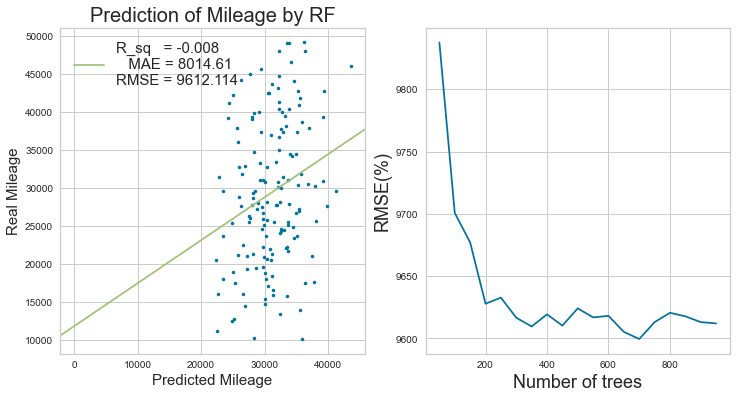

In [148]:
f = plot.figure(figsize=(12,6))
ax1 = f.add_subplot(121); ax2 = f.add_subplot(122)

ax1.plot(predictions,milg_test, 'b.')
ax1.set_title("Prediction of Mileage by RF", fontsize=20);
m1, b1 = np.polyfit(predictions,milg_test.astype(np.float), 1)
ax1.axline(xy1=(0, b1), slope=m1, color='g', label=f'R_sq   = {R_sq}\n   MAE = {MAE}\nRMSE = {RMSE}') # 
ax1.set_xlabel("Predicted Mileage", fontsize=15) 
ax1.set_ylabel("Real Mileage", fontsize=15)
ax1.legend(fontsize=15)

ax2.plot(ntreelist, rmseoos)
ax2.set_xlabel("Number of trees", fontsize=18) 
ax2.set_ylabel("RMSE(%)", fontsize=18)


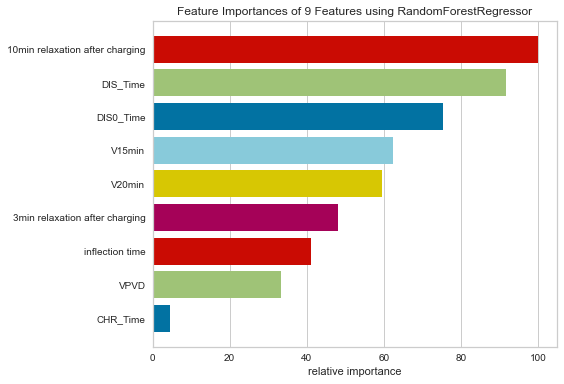

<AxesSubplot:title={'center':'Feature Importances of 9 Features using RandomForestRegressor'}, xlabel='relative importance'>

In [89]:
from yellowbrick.model_selection import FeatureImportances
visualizer = FeatureImportances(model,labels=["CHR_Time","DIS_Time","V15min","V20min","DIS0_Time","3min relaxation after charging","10min relaxation after charging","inflection time","VPVD"])
visualizer.fit(features_train, milg_train)
visualizer.show()

In [4]:
'''合併796個檔案中，最爛的那一顆電池'''
import os
import numpy as np
import pandas as pd

all_posit = []
stack = np.array(['Number','Module','Mileage','MIS','B_SN','Battery','Org_Module','M_SN','DIS0_Wh','Norm_D0','CHR_Wh','DIS_Wh','Ratio_Wh','CHR_Time','DIS_Time','Ratio_Time','V15min','V20min','V25min','V30min','V35min','DIS0_Time','RV10s','VDT','BIN','Out_Battery','Out_Module','FG_SN','Station','Date','Time','Model','VPVD','TPtE','VEOC','VDeltaMax','RSN','GSN','B_SN','Battery','Org_Module','M_SN','DIS0_Wh','Norm_D0','CHR_Wh','DIS_Wh','Ratio_Wh','CHR_Time','DIS_Time','Ratio_Time','V15min','V20min','V25min','V30min','V35min','DIS0_Time','RV10s','VDT','BIN','Out_Battery','Out_Module','FG_SN','Station','Date','Time','Model','VPVD','TPtE','VEOC','VDeltaMax','RSN','GSN'])
# print("原始的stack\n",stcak); print(type(stcak)); print(len(stcak))
for dirpath, dirnames, filenames in os.walk(r"C:\Users\Chun-Po\Documents\Python Scripts\B&A to NTU"):
    for f in filenames:
        a = os.path.join(dirpath,f)
        if os.path.isfile(a):     #判斷是否是檔案,是檔案才打開
            if '.xlsx' in a:
                a1 = pd.read_excel(a); a2 = a1.iloc[:,:].values                # print("a2 =\n",a2); print(type(a2))
                x_dim = len(a2); y_dim = len(a2[0])                # 求矩陣的行和列；print(x_dim); print(y_dim)
                if y_dim == 72:
                    # a2中容量最低的電池
                    dissoh = a2[:,48]*28800/7     # print("dissoh(%)\n", dissoh)
                    posit = np.argmin(dissoh)     # print("posit : ", posit)
                    all_posit.append(posit)
                    a3 = a2[posit,:]     # print("worst", a3)
                    stack = np.vstack((stack,a3))

# print("all_posit = ", all_posit)
# print("新的stack\n",stack)
x_dim = len(stack); y_dim = len(stack[0])
print(x_dim); print(y_dim)
# 統一格式,變成字串
Stack = np.empty((x_dim,y_dim), dtype = object);
for i in range(x_dim):          
    for j in range(y_dim):
        Stack[i,j] = str(stack[i,j])
print("統一的stack\n",Stack);
x2_dim = len(Stack); y2_dim = len(Stack[0])
print(x2_dim); print(y2_dim)
# delimiter=',',fmt='%s'兩個一起用就可以輸出成excel了；raw表示不轉換成字串\str表示全部轉換成字串
file = np.asarray(Stack)
np.savetxt(r'C:\Users\Chun-Po\Documents\Python Scripts\儲存分析結果(數據)\皓恆任務.csv',file,delimiter=',',fmt='%s')


all_posit =  [16, 20, 26, 17, 16, 19, 25, 4, 32, 26, 10, 21, 27, 10, 16, 23, 21, 21, 12, 22, 28, 29, 31, 24, 27, 11, 27, 16, 10, 27, 16, 8, 11, 32, 9, 6, 3, 9, 10, 15, 30, 23, 10, 5, 16, 19, 19, 27, 10, 21, 16, 28, 30, 31, 22, 24, 12, 15, 31, 18, 15, 23, 11, 21, 30, 10, 15, 28, 2, 24, 20, 25, 31, 28, 32, 25, 10, 9, 5, 16, 2, 25, 19, 14, 28, 27, 31, 7, 20, 9, 3, 27, 18, 32, 20, 15, 18, 8, 32, 10, 27, 29, 16, 30, 32, 12, 15, 32, 32, 19, 10, 32, 8, 14, 25, 14, 31, 18, 32, 8, 26, 24, 29, 23, 22, 27, 10, 11, 23, 4, 22, 18, 4, 9, 16, 25, 6, 17, 20, 30, 30, 16, 20, 11, 1, 27, 18, 20, 18, 27, 21, 28, 28, 25, 14, 12, 20, 31, 26, 18, 20, 29, 28, 2, 10, 30, 19, 19, 14, 20, 13, 14, 20, 31, 14, 9, 9, 9, 20, 7, 17, 28, 21, 22, 31, 24, 23, 15, 3, 9, 6, 15, 20, 29, 22, 29, 3, 27, 22, 9, 3, 24, 16, 16, 21, 11, 20, 26, 2, 13, 3, 23, 28, 15, 31, 1, 26, 27, 30, 17, 15, 22, 22, 29, 27, 8, 0, 24, 11, 10, 14, 24, 23, 9, 17, 8, 17, 31, 10, 24, 20, 14, 23, 28, 15, 33, 5, 6, 24, 19, 20, 25, 26, 25, 8, 26, 3, 6,

In [6]:
real_posit = []
for i in range(len(all_posit)):
    real = all_posit[i]+i*34
    real_posit.append(real)
# print("real_posit", real_posit)

In [17]:
rexinf = r'C:\Users\Chun-Po\Documents\Python Scripts\儲存分析結果(數據)\反曲點2+弛豫+VPVD (For Powereign).csv'
data_rexinf = np.genfromtxt(rexinf, dtype = None, delimiter = ',', skip_header = 0, filling_values = 0, invalid_raise = False, encoding = 'latin-1')[:,[4,7,18,21]]
print(data_rexinf)

[[-1.82e-01 -2.27e-01  1.29e+03  8.50e+00]
 [-1.85e-01 -2.31e-01  1.28e+03  8.52e+00]
 [-1.97e-01 -2.48e-01  1.27e+03  8.59e+00]
 ...
 [-2.30e-01 -3.03e-01  1.20e+03  8.68e+00]
 [-2.35e-01 -3.04e-01  1.21e+03  8.69e+00]
 [-2.20e-01 -2.83e-01  1.13e+03  8.68e+00]]


In [18]:
broken = data_rexinf[real_posit,:]
print("broken", broken)

broken [[-2.18e-01 -2.77e-01  1.22e+03  8.67e+00]
 [-2.34e-01 -3.06e-01  1.23e+03  8.70e+00]
 [-2.55e-01 -3.27e-01  1.21e+03  8.73e+00]
 ...
 [-2.90e-01 -3.88e-01  1.23e+03  8.73e+00]
 [-2.54e-01 -3.34e-01  1.20e+03  8.73e+00]
 [-2.48e-01 -3.20e-01  1.16e+03  8.73e+00]]


In [19]:
np.savetxt(r'C:\Users\Chun-Po\Documents\Python Scripts\儲存分析結果(數據)\皓恆任務_Add.csv',broken,delimiter=',',fmt='%s')

In [3]:
print(stack)

[['Number' 'Module' 'Mileage' ... 'VDeltaMax' 'RSN' 'GSN']
 [16 'M17' 58135 ... 1.57 'DK00289' 'DK00290']
 [20 'M21' 45574 ... 1.48 'DK00281' 'DK00282']
 ...
 [13 'M14' nan ... 1.83 'DK00273' 'DK00276']
 [19 'M20' nan ... 1.24 'DK00292' 'DK00287']
 [22 'M23' 48102 ... 1.59 'DK00296' 'DK00297']]


In [11]:
'''合併796個檔案中，最爛的那一顆電池'''
import os
import numpy as np
import pandas as pd

stack = np.array(['Number','Module','Mileage','MIS','B_SN','Battery','Org_Module','M_SN','DIS0_Wh','Norm_D0','CHR_Wh','DIS_Wh','Ratio_Wh','CHR_Time','DIS_Time','Ratio_Time','V15min','V20min','V25min','V30min','V35min','DIS0_Time','RV10s','VDT','BIN','Out_Battery','Out_Module','FG_SN','Station','Date','Time','Model','VPVD','TPtE','VEOC','VDeltaMax','RSN','GSN','B_SN','Battery','Org_Module','M_SN','DIS0_Wh','Norm_D0','CHR_Wh','DIS_Wh','Ratio_Wh','CHR_Time','DIS_Time','Ratio_Time','V15min','V20min','V25min','V30min','V35min','DIS0_Time','RV10s','VDT','BIN','Out_Battery','Out_Module','FG_SN','Station','Date','Time','Model','VPVD','TPtE','VEOC','VDeltaMax','RSN','GSN'])
# print("原始的stack\n",stcak); print(type(stcak)); print(len(stcak))
for dirpath, dirnames, filenames in os.walk(r"C:\Users\Chun-Po\Documents\Python Scripts\B&A to NTU\Exp_測試代碼用的資料集"):
    for f in filenames:
        a = os.path.join(dirpath,f)
        if os.path.isfile(a):     #判斷是否是檔案,是檔案才打開
            if '.xlsx' in a:
                a1 = pd.read_excel(a); a2 = a1.iloc[:,:].values                # print("a2 =\n",a2); print(type(a2))
                x_dim = len(a2); y_dim = len(a2[0])                # 求矩陣的行和列；print(x_dim); print(y_dim)
                if y_dim == 72:
                    # a2中容量最低的電池
                    dissoh = a2[:,48]*28800/7
                    # print("dissoh(%)\n", dissoh)
                    posit = np.argmin(dissoh)
                    print("posit : ", posit)
                    a3 = a2[posit,:]
                    print("worst", a3)
                    stack = np.vstack((stack,a3))

print("新的stack\n",stack)
x_dim = len(stack); y_dim = len(stack[0])
print(x_dim); print(y_dim)
# 統一格式,變成字串
Stack = np.empty((x_dim,y_dim), dtype = object);
for i in range(x_dim):          
    for j in range(y_dim):
        Stack[i,j] = str(stack[i,j])
print("統一的stack\n",Stack);
x2_dim = len(Stack); y2_dim = len(Stack[0])
print(x2_dim); print(y2_dim)
# delimiter=',',fmt='%s'兩個一起用就可以輸出成excel了；raw表示不轉換成字串\str表示全部轉換成字串
file = np.asarray(Stack)
np.savetxt(r'C:\Users\Chun-Po\Documents\Python Scripts\儲存分析結果(數據)\皓恆任務.csv',file,delimiter=',',fmt='%s')


posit :  16
worst [16 'M17' 58135 25.9 '2345H133060153260001' 'J19T01272' 'M20'
 '173Q1P11918K' 20.381 0.834603 30.507 27.2312 0.892621
 0.02430555555555556 0.02388888888888889 0.982857 8.0096 8.1552 8.3126
 8.5054 8.6721 0.0190625 6.2469 108 'P' 'J19Q00019' 'M17' nan 'ST-01'
 Timestamp('2019-11-21 00:00:00') 0.4556134259259259 '34M' nan nan nan nan
 nan nan 'T19B25001' 'J22T00910' 'M17' '173Q1P11918K' 1.9472 0.0945811
 13.697 7.25748 0.52986 0.01033564814814815 0.006030092592592593 0.583427
 nan nan nan nan nan 0.001793981481481481 6.861 2 'NG' nan nan nan 'ST-03'
 Timestamp('2022-03-17 00:00:00') 0.5036111111111111 '34M' 8.9474 108
 8.9433 1.57 'DK00289' 'DK00290']
posit :  20
worst [20 'M21' 45574 28.2 '2345M133070132150085' 'J19T01326' 'M32'
 '072OMN03182Y' 20.685 0.818171 30.529 26.8662 0.880021
 0.02430555555555556 0.02366898148148148 0.97381 8.0091 8.1656 8.3336
 8.5378 8.7005 0.019375 6.2496 124 'P' 'J19Q00028' 'M21' nan 'ST-03'
 Timestamp('2019-11-25 00:00:00') 0.5467592592592

In [2]:
'''合併796個檔案中，最爛的那一顆電池'''
import os
import numpy as np
import pandas as pd

stack = np.array(['Number','Module','Mileage','MIS','B_SN','Battery','Org_Module','M_SN','DIS0_Wh','Norm_D0','CHR_Wh','DIS_Wh','Ratio_Wh','CHR_Time','DIS_Time','Ratio_Time','V15min','V20min','V25min','V30min','V35min','DIS0_Time','RV10s','VDT','BIN','Out_Battery','Out_Module','FG_SN','Station','Date','Time','Model','VPVD','TPtE','VEOC','VDeltaMax','RSN','GSN','B_SN','Battery','Org_Module','M_SN','DIS0_Wh','Norm_D0','CHR_Wh','DIS_Wh','Ratio_Wh','CHR_Time','DIS_Time','Ratio_Time','V15min','V20min','V25min','V30min','V35min','DIS0_Time','RV10s','VDT','BIN','Out_Battery','Out_Module','FG_SN','Station','Date','Time','Model','VPVD','TPtE','VEOC','VDeltaMax','RSN','GSN'])
# print("原始的stack\n",stcak); print(type(stcak)); print(len(stcak))
for dirpath, dirnames, filenames in os.walk(r"C:\Users\Chun-Po\Documents\Python Scripts\B&A to NTU\Exp_測試代碼用的資料集"):
    for f in filenames:
        a = os.path.join(dirpath,f)
        if os.path.isfile(a):     #判斷是否是檔案,是檔案才打開
            if '.xlsx' in a:
                a1 = pd.read_excel(a); a2 = a1.iloc[:,:].values                # print("a2 =\n",a2); print(type(a2))
                x_dim = len(a2); y_dim = len(a2[0])                # 求矩陣的行和列；print(x_dim); print(y_dim)
                if y_dim == 72:
                    # a2中容量最低的電池
                    stack = np.vstack((stack,a2))

print("新的stack\n",stack)
x_dim = len(stack); y_dim = len(stack[0])
print(x_dim); print(y_dim)
# 統一格式,變成字串
Stack = np.empty((x_dim,y_dim), dtype = object);
for i in range(x_dim):          
    for j in range(y_dim):
        Stack[i,j] = str(stack[i,j])
print("統一的stack\n",Stack);
x2_dim = len(Stack); y2_dim = len(Stack[0])
print(x2_dim); print(y2_dim)
# delimiter=',',fmt='%s'兩個一起用就可以輸出成excel了；raw表示不轉換成字串\str表示全部轉換成字串
file = np.asarray(Stack)
np.savetxt(r'C:\Users\Chun-Po\Documents\Python Scripts\儲存分析結果(數據)\皓恆任務.csv',file,delimiter=',',fmt='%s')


新的stack
 [['Number' 'Module' 'Mileage' ... 'VDeltaMax' 'RSN' 'GSN']
 [0 'M01' 58135 ... 1.43 'DK00291' 'DK00293']
 [1 'M02' 58135 ... 1.39 'DK00291' 'DK00293']
 ...
 [31 'M32' 18001 ... 1.23 'DK00107' 'DK00108']
 [32 'M33' 18001 ... 1.19 'DK00107' 'DK00108']
 [33 'M34' 18001 ... 1.29 'DK00107' 'DK00108']]
205
72
統一的stack
 [['Number' 'Module' 'Mileage' ... 'VDeltaMax' 'RSN' 'GSN']
 ['0' 'M01' '58135' ... '1.43' 'DK00291' 'DK00293']
 ['1' 'M02' '58135' ... '1.39' 'DK00291' 'DK00293']
 ...
 ['31' 'M32' '18001' ... '1.23' 'DK00107' 'DK00108']
 ['32' 'M33' '18001' ... '1.19' 'DK00107' 'DK00108']
 ['33' 'M34' '18001' ... '1.29' 'DK00107' 'DK00108']]
205
72


# Powereign tasks_驗證梁老師_V25+Dis0

In [149]:
import sklearn
from sklearn.preprocessing import StandardScaler
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

a = r'C:\Users\Chun-Po\Documents\Python Scripts\儲存分析結果(數據)\合併796檔案(raw).csv'     # C:\Users\Chun-Po\Documents\Python Scripts\B&A to NTU\NonRMA\T20622004_B&A\J21T03555
dat = np.genfromtxt(a, dtype = None, delimiter = ',', skip_header = 0, filling_values = 0, usecols=[48,52,55], invalid_raise = False, encoding = 'latin-1')
[Row,Column] = data.shape
data = dat[1:,:]

In [150]:
numer = np.empty((27064,3), dtype = object);
for i in range(27064):
    for j in range(3):
        value = data[i,j].replace('nan','0')
        if j == 0:
            if np.round(float(value)*24/91,4) < 1.001:
                numer[i,j] = np.round(float(value)*24/91,4)
            else:
                numer[i,j] = 1
        else:
            numer[i,j] = float(value)
err = [w for w,x in enumerate(numer[:,1]) if x==0]     # 刪掉無數據(nan)或數據=0的.astype(np.float32)
number = np.delete(numer[:,:], (err),axis=0);     # length_numer 27064; length_number 18631
print(number)

[[1 8.3472 1500.0]
 [1 8.2561 1710.0]
 [1 8.3238 1570.0]
 ...
 [0.6814 8.8351 940.0]
 [0.831 8.6773 1280.0]
 [0.921 8.5553 1350.0]]


In [151]:
X = number[:,1:3]
y = number[:,0:1]*100
print(X)
print(y)

[[8.3472 1500.0]
 [8.2561 1710.0]
 [8.3238 1570.0]
 ...
 [8.8351 940.0]
 [8.6773 1280.0]
 [8.5553 1350.0]]
[[100]
 [100]
 [100]
 ...
 [68.14]
 [83.1]
 [92.10000000000001]]


In [154]:
import random
import torch
from torch import nn, optim
import math
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

scaler = pp.MinMaxScaler().fit(X)     # 默認數據壓縮范圍為[0,1]
data_var = scaler.transform(X)
data_SOH = y
data_all = np.hstack((data_SOH, data_var))     # 製作normalized features+未調整SOH數據
print(data_all)

[[100 0.23192134521731234 0.5655459010200226]
 [100 0.14821280896811562 0.6448809973554968]
 [100 0.2104199209776727 0.5919909331318473]
 ...
 [68.14 0.6802352292566392 0.353985644125425]
 [83.1 0.5352384452816326 0.48243294295428785]
 [92.10000000000001 0.4231370026647072 0.5088779750661125]]


In [184]:
import time

t1 = time.monotonic()

features_train, features_test, soh_train, soh_test = train_test_split(data_all[:,1:3], data_all[:,0:1], test_size=0.2, random_state=100)
#print("features_train\n", features_train[0])
X_train = torch.from_numpy(features_train.astype(np.float64))
y_train = torch.from_numpy(soh_train.astype(np.float64))
X_test = torch.from_numpy(features_test.astype(np.float64))
y_test = torch.from_numpy(soh_test.astype(np.float64))

D = 2  # dimensions
C = 1  # num_classes
H1 = 100  # num_hidden_units_1
H2 = 20  # num_hidden_units_2

learning_rate = 1e-2
lambda_l2 = 5e-5
n_networks = 1     # Number of networks
criterion = torch.nn.MSELoss()     # nn package also has different loss functions. We use MSE for a regression task
totalerr_train = []; totalerr_test = []; total_corr = [];
train_set = []; test_set = []; eveloss = [];
models = list(); y_pretrain = list()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for mod in range(n_networks):
    model = nn.Sequential(
        nn.Linear(D, H1),
        nn.ReLU(), 
        nn.Linear(H1, H2),
        nn.ReLU(),
        nn.Linear(H2, C),
    )
    model.to(device)
  # Append models
    models.append(model)
  # Use the optim package to apply ADAM for our parameter updates
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)     # built-in L2
    for t in range(50000):
      # Feed forward to get the logits     # print("test_set = ", test_set);     # 檢查是否正確取樣
        y_pred = model(X_train.float())
        if t == 0:
            y_pretrain.append(y_pred.detach())
          # Compute the loss and accuracy
        loss = torch.sqrt(criterion(y_pred.float(), y_train.float()))
        eveloss.append(np.round(loss.item(),6))
        print(f"[EPOCH]: {t}, [LOSS]: {loss.item():.6f}")
        display.clear_output(wait=True)
      # zero the gradients before running
      # the backward pass.
        optimizer.zero_grad()
      # Backward pass to compute the gradient of loss w.r.t our learnable params. 
        loss.backward()
      # Update params
        optimizer.step()
        if t == 49999:
            totalerr_train.append(np.round(loss.item(),6))  
          ## Testing
            y_test_pred = model(X_test.float())
          # Compute the loss and accuracy
            loss_test = torch.sqrt(criterion(y_test_pred.float(), y_test.float()))
            y_test_array = []; y_test_pred_array = [];
            for ii in range(len(y_test)):
                y_test_array.append(y_test.detach().numpy()[ii][0].astype(np.float64))     # [ii]後面有時候要加[0]有時不用,使用時請注意資料集種類
                y_test_pred_array.append(y_test_pred.detach().numpy()[ii][0].astype(np.float64))
            R_sq = np.round(r2_score(y_test_pred_array, y_test_array),3)
            MAE = np.round(mean_absolute_error(y_test_pred_array, y_test_array),3)
            totalerr_test.append(np.round(loss_test.item(),6))
            total_corr.append(np.round(R_sq,3))

t2 = time.monotonic()
print("time elapsed:" + str(t2-t1) + " seconds")
# time elapsed:2556.8600000000442 seconds (Liang,lr=0.006)
# time elapsed:2633.5310000000172 seconds (Liang,lr=0.01)

time elapsed:2633.5310000000172 seconds


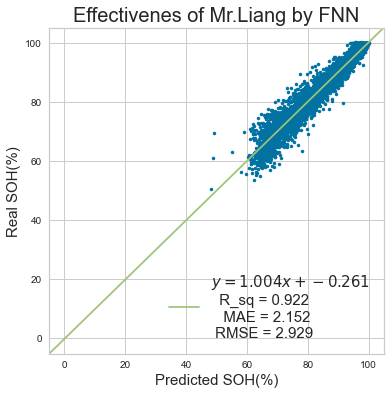

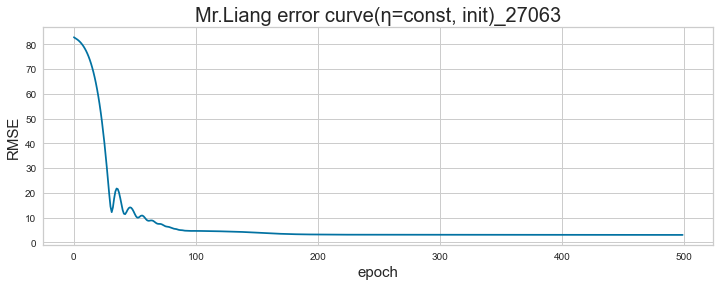

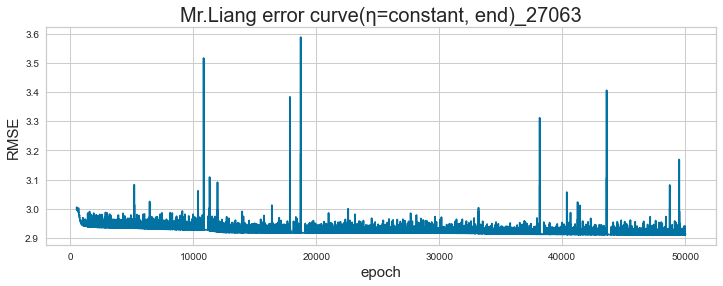

hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20;;,learning_rate = 0.01, lambda_l2 = 5e-05
Result_train =  [2.913064]
2.913
Result_test =  [2.928826]
2.929
total_corr(^2) =  [0.922]
0.922


In [185]:
plt.figure(figsize=(6,6))
plt.plot(y_test_pred_array, y_test_array, 'b.');     #
m1, b1 = np.polyfit(y_test_pred_array, y_test_array, 1);
plt.axline(xy1=(0, b1), slope=m1, color='g',
           label=f'$y = {m1:.3f}x +{b1:.3f}$\n  R_sq = {R_sq}\n   MAE = {MAE}\n RMSE = {loss_test:.3f}')
plt.xlabel("Predicted SOH(%)", fontsize=15)
plt.ylabel("Real SOH(%)", fontsize=15)
plt.title("Effectivenes of Mr.Liang by FNN", fontsize=20);
plt.legend(fontsize=15)
plt.savefig("Effectivenes of Mr.Liang" + "_Round " + f"{i}" + ".jpg"); plt.show();  #save as jpg
plt.figure(figsize=(12,4))
plt.plot(np.arange(0,500,1),eveloss[0:500]);     # ,'ro'
plt.xlabel("epoch", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.title("Mr.Liang error curve(η=const, init)" + "_" + f"{i}", fontsize=20);
plt.savefig("Mr.Liang error curve(η=const, init)" + "_" + f"{i}" + ".jpg"); plt.show();     #save as jpg
plt.figure(figsize=(12,4))
plt.plot(np.arange(499,50000,1),eveloss[499:50000]);     # ,'ro'
plt.xlabel("epoch", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.title("Mr.Liang error curve(η=constant, end)" + "_" + f"{i}", fontsize=20);
plt.savefig("Mr.Liang error curve(η=constant, end)" + "_" + f"{i}" + ".jpg"); plt.show();     #save as jpg'''

print("hyperparameters = ", 'Epoch = ' + f"{t+1}" + ',' + ' hidden_1= ' + f"{H1}" + ';;' + ' hidden_2= ' + f"{H2}" + ';;' + ',' + 'learning_rate = ' + f"{learning_rate}" + ', ' + "lambda_l2 = " + f"{lambda_l2}")
# print("hyperparameters = ", 'Epoch = ' + f"{t+1}" + ',' + ' hidden_1= ' + f"{H1}" + ';;' + ' hidden_2= ' + f"{H2}" + ';;' + ' hidden_3= ' + f"{H3}" + ',' + 'learning_rate = ' + f"{learning_rate}" + ', ' + "lambda_l2 = " + f"{lambda_l2}")
# print("hyperparameters = ", 'Epoch = ' + f"{t+1}" + ',' + ' hidden_1= ' + f"{H1}" + ';;' + ' hidden_2= ' + f"{H2}" + ';;' + ' hidden_3= ' + f"{H3}" + ' hidden_4= ' + f"{H4}" + ',' + 'learning_rate = ' + f"{learning_rate}" + ', ' + "lambda_l2 = " + f"{lambda_l2}")
print("Result_train = ", totalerr_train); print(np.round(np.mean(totalerr_train),3))
print("Result_test = ", totalerr_test); print(np.round(np.mean(totalerr_test),3))
print("total_corr(^2) = ", total_corr); print(np.round(np.mean(total_corr),3))

In [ ]:
(2022.1202.0919~1354)
hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20;;,learning_rate = 0.006, lambda_l2 = 5e-05
Result_train =  [2.921266, 2.928637, 2.905412, 2.92205, 2.929612]
2.921
Result_test =  [2.965796, 2.926892, 2.980977, 2.891124, 2.948177]
2.943
total_corr(^2) =  [0.92, 0.921, 0.921, 0.923, 0.92]
0.921

(2022.1130.1050~1410)
hyperparameters =  Epoch = 50000, hidden_1= 100;; hidden_2= 20;;,learning_rate = 0.01, lambda_l2 = 5e-05
Result_train =  [2.904466, 2.913442, 2.910402, 2.935453, 2.911428]
2.915
Result_test =  [2.961665, 2.93033, 2.985918, 2.898908, 2.928267]
2.941
total_corr(^2) =  [0.921, 0.921, 0.921, 0.922, 0.921]
0.921

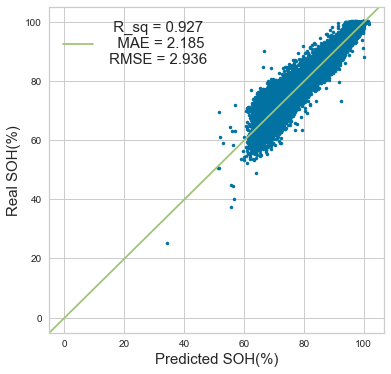

In [169]:
data_SOH = data_all[:,0:1]
data_var = data_all[:,1:3]     ## 合併數據: data = np.hstack((data_SOH, data_var))     # 製作normalized features+未調整SOH數據
data_SOH_st = torch.from_numpy(data_SOH.astype(np.float64))
data_var_st = torch.from_numpy(data_var.astype(np.float64))

data_SOH_st_pred = model(data_var_st.float())

# # # detach
data_SOH_st_pred_detach = data_SOH_st_pred.detach().numpy()     # [ii][0].astype(np.float64)
data_SOH_st_detach = data_SOH_st.detach().numpy()     # [ii][0].astype(np.float64)
# print(data_SOH_st_pred_detach); print(data_SOH_st_detach)
poster_pred = [];
poster_real = [];
for ii in range(len(data_SOH_st_detach)):
    poster_real.append(data_SOH_st_detach[ii][0].astype(np.float64))
    poster_pred.append(data_SOH_st_pred_detach[ii][0].astype(np.float64))

# Evaluate the cost
R_sq = np.round(r2_score(poster_real, poster_pred),3)
MAE = np.round(mean_absolute_error(poster_real, poster_pred),3)
RMSE = np.round(np.sqrt(mean_squared_error(poster_real,poster_pred)),3)

# Plot the result
plt.figure(figsize=(6,6))
plt.plot(poster_pred, poster_real, 'b.');     #
m1, b1 = np.polyfit(poster_pred, poster_real, 1);
plt.axline(xy1=(0, b1), slope=m1, color='g', label=f'  R_sq = {R_sq}\n   MAE = {MAE}\n RMSE = {RMSE}') # 
plt.xlabel("Predicted SOH(%)", fontsize=15)
plt.ylabel("Real SOH(%)", fontsize=15)
# plt.title("" + "_" + f"{i}", fontsize=20);
plt.legend(fontsize=15)
plt.savefig("Powereign Task" + ".jpg"); plt.show();  #save as jpg


In [180]:
import torch
from torch import nn, optim
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
import pylab as plot
import time

t1 = time.monotonic()

features_train, features_test, pred_soh_train, pred_soh_test = train_test_split(data_all[:,1:3], data_all[:,0:1].ravel(), test_size=0.2, random_state=100)

'''調整超參數並衡量訓練效果。以下示範"森林中的樹木量"不同時,模型損失的變化'''
rmseoos = []
ntreelist = range(50, 800, 50)
for itrees in ntreelist:
    depth = None
    maxfeat = 2
    model = ensemble.RandomForestRegressor(n_estimators=itrees, max_depth=depth, max_features=maxfeat, oob_score=False, random_state=100)
    model.fit(features_train, pred_soh_train)
    predictions = model.predict(features_test)
    rmseoos.append(math.sqrt(mean_squared_error(pred_soh_test, predictions)))
R_sq = np.round(model.fit(features_train, pred_soh_train).score(features_test, pred_soh_test),3)
MAE = np.round(mean_absolute_error(predictions,pred_soh_test),3)
RMSE = np.round(np.sqrt(mean_squared_error(predictions,pred_soh_test)),3)
print("RMSE(%) = ", RMSE)

t2 = time.monotonic()
print("time elapsed:" + str(t2-t1) + "seconds")

RMSE(%) =  3.293
time elapsed:132.03200000000652seconds


C:\Users\Chun-Po\miniconda3\envs\env_pytorch\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Text(0, 0.5, 'RMSE(%)')

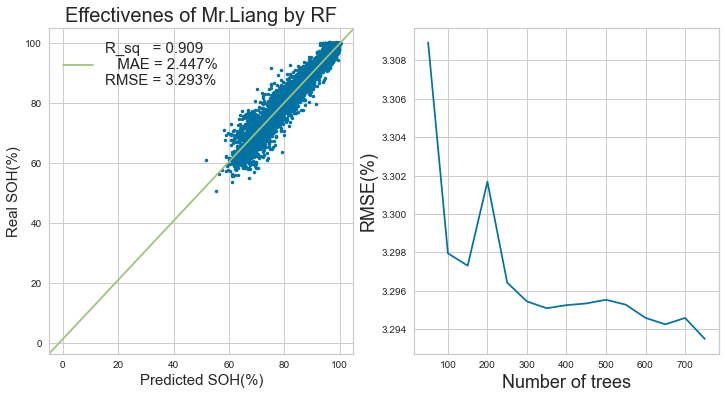

In [181]:
'''畫圖:最後一次調整的超參數，其訓練出來的預測值和實際值的擬合圖，以及不同超參數下的模型損失'''
f = plot.figure(figsize=(12,6))
ax1 = f.add_subplot(121); ax2 = f.add_subplot(122)

ax1.plot(predictions,pred_soh_test, 'b.')
m1, b1 = np.polyfit(predictions,pred_soh_test.astype(np.float), 1)
ax1.set_title("Effectivenes of Mr.Liang by RF", fontsize=20);
ax1.axline(xy1=(0, b1), slope=m1, color='g', label=f'R_sq   = {R_sq}\n   MAE = {MAE}%\nRMSE = {RMSE}%') # 
ax1.set_xlabel("Predicted SOH(%)", fontsize=15) 
ax1.set_ylabel("Real SOH(%)", fontsize=15)
ax1.legend(fontsize=15)

ax2.plot(ntreelist, rmseoos)
ax2.set_xlabel("Number of trees", fontsize=18) 
ax2.set_ylabel("RMSE(%)", fontsize=18)

##RMSE(%) =  3.294
##time elapsed:204.625seconds

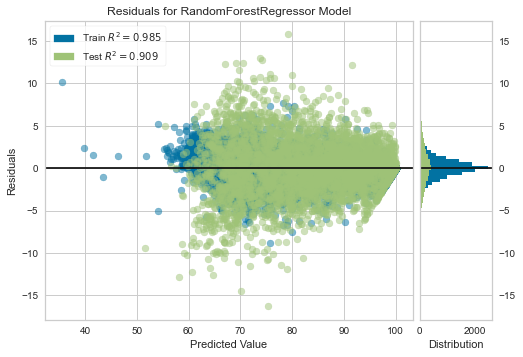

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [206]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(model.fit(features_train, pred_soh_train),train_alpha=0.5, test_alpha=0.5)
visualizer.fit(features_train, pred_soh_train)
visualizer.score(features_test, pred_soh_test)
visualizer.poof()

In [207]:
data_all[:,1:3], data_all[:,0:1].ravel()
predictions_all = model.predict(data_all[:,1:3])
R_sq2 = np.round(r2_score(predictions_all, data_all[:,0:1]),3)
MAE2 = np.round(mean_absolute_error(predictions_all, data_all[:,0:1]),3)
RMSE2 = np.round(np.sqrt(mean_squared_error(predictions_all, data_all[:,0:1])),3)
print("R_sq2",R_sq2)
print("MAE2",MAE2)
print("RMSE2",RMSE2)

R_sq2 0.968
MAE2 1.253
RMSE2 1.883


In [223]:
print(data_all[:,0:1])

[[100]
 [100]
 [100]
 ...
 [68.14]
 [83.1]
 [92.10000000000001]]


In [226]:
Realsoh = []
for i in range(len(data_all[:,0:1])):
    Realsoh.append(data_all[:,0:1][i].astype(np.float64))
pred_Realsoh = np.array(Realsoh)
print(pred_Realsoh)

[[100.  ]
 [100.  ]
 [100.  ]
 ...
 [ 68.14]
 [ 83.1 ]
 [ 92.1 ]]


C:\Users\Chun-Po\miniconda3\envs\env_pytorch\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

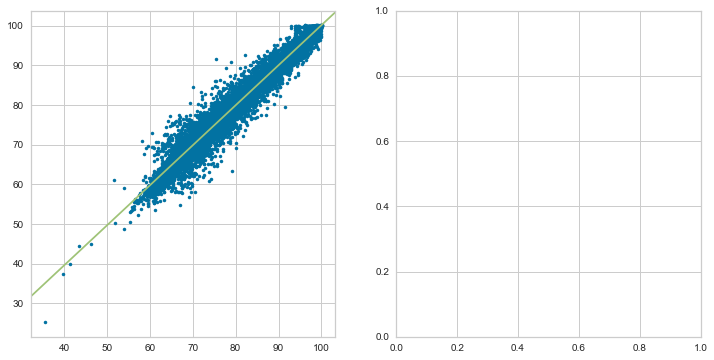

In [228]:
f = plot.figure(figsize=(12,6))
ax1 = f.add_subplot(121); ax2 = f.add_subplot(122)

ax1.plot(predictions_all, pred_Realsoh, 'b.')
m1, b1 = np.polyfit(predictions_all, pred_Realsoh, 1)
ax1.axline(xy1=(0, b1), slope=m1, color='g', label=f'R_sq   = {R_sq2}\n   MAE = {MAE2}%\nRMSE = {RMSE2}%'); # 
ax1.set_xlabel("Predicted SOH(%)", fontsize=15) 
ax1.set_ylabel("Real SOH(%)", fontsize=15)
ax1.legend(fontsize=15)

ax2.plot(ntreelist, rmseoos)
ax2.set_xlabel("Number of trees", fontsize=18) 
ax2.set_ylabel("RMSE(%)", fontsize=18)

ValueError: Expected 2D array, got 1D array instead:
array=[98.69967  98.558945 99.50161  ... 66.884575 83.2436   91.10759 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

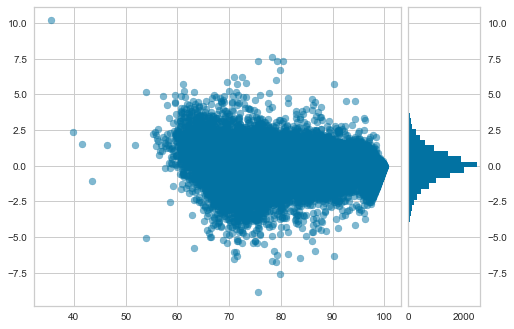

In [233]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(model.fit(features_train, pred_soh_train),train_alpha=0.5, test_alpha=0.5)
visualizer.fit(features_train, pred_soh_train)
visualizer.score(predictions_all, data_all[:,0:1])
visualizer.poof()

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
regr = MLPRegressor(hidden_layer_sizes=(100,20), activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto',
                    learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True,
                    random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
                    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08,
                    n_iter_no_change=10, max_fun=15000).fit(X_train, y_train)
predictions = regr.predict(X_test)

R_sq = np.round(regr.score(X_test, y_test),3)
MAE = np.round(mean_absolute_error(predictions,y_test),3)
RMSE = np.round(np.sqrt(mean_squared_error(predictions,y_test)),3)
print("R_sq = ", R_sq)
print(" MAE = ", MAE)
print("RMSE = ", RMSE)